In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Importing the databases that we need


In [ ]:
# loading in statistics for college players
college_stats = pd.read_csv('all_college_data.csv')

# removing college players that were not drafted and don't have advanced stats
college_stats = college_stats[college_stats['Pick'].notna()]
college_stats = college_stats.dropna(subset = ['PER'])

# dropping all the coloumns that are not going to be used in estimation
cols = ['Player', 'Pick', 'GP', 'MPG', 'PER', 'ORB', 'DRB', 'APG', 'BPG', 'SPG', 'FTM', 'FT%', '3PM', '3P%', 'TS%', 'TOV', 'eFG%', 'ORtg', 'DRtg']
college_stats = college_stats[cols]

# loading in career stats for NBA
nba_stats = pd.read_csv('draft-data-20-years.csv')

# removing all columns except win share which is our target
nba_stats = nba_stats[['Player', 'WS']]

# joining college stats on player Name to add target of WS
data = college_stats.set_index('Player').join(nba_stats.set_index('Player'))
data.reset_index(inplace=True)


# making sure we have a WS for every player in our data set, remove those who don't 
data = data[data['WS'].notna()]

data

Cleaning the Data

In [ ]:
# filling in means for NaN values in stats
# not many NaN values, because we are taking drafted players only(i.e. high value players, which typically have complete statistics)
# therefore mean is appropriate

# we do not do this for picks over WS cause we already filter out NaN values for them
cols = ['Player', 'Pick', 'GP', 'MPG', 'PER', 'ORB', 'DRB', 'APG', 'BPG', 'SPG', 'FTM', 'FT%', '3PM', '3P%', 'TS%', 'TOV', 'eFG%', 'ORtg', 'ORtg']
cols_to_adjust = cols[1:]

for col in cols_to_adjust:
  data[col] = data[col].fillna(data[col].mean())

data.head() # cleaned data

Correlation Matrix

In [ ]:
corr = data.corr().abs()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Splitting the Data

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error


# we remove pick as the goal is to determine the value of a college prospect
# therefore their draft order cannot be considered although it has a high correlation
X = data.drop(['Pick','Player', 'WS'], axis = 1)
y = data['WS']

# split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train

Preprocessing Data

In [7]:
from sklearn import preprocessing

# defining an object of MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()

# normalize values between 0 and 1 using the training data
X_train_scaled = min_max_scaler.fit_transform(X_train)

# visualizing shape of scaled data
X_train_scaled.shape

(286, 17)

Linear Regression

In [8]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate

# defining the model as an object of LinearRegression()
lin_model = linear_model.LinearRegression()

# fit the model on the scaled training data
lin_model.fit(X_train_scaled, y_train)

# calculating scores
lin_model.score(X_train_scaled, y_train)

0.13630552875816937

In [ ]:
# calculate the predicted values for training data
y_pred_train = lin_model.predict(X_train_scaled)

# visualize the difference between actual and predicted data using scatter plot
plt.scatter(y_train, y_pred_train)
plt.xlabel("Actual value")
plt.ylabel("Predicted value")
plt.title("Actual vs. Predicted - Train Set")
plt.show()

Decision Tree

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test MSE: 14.5009
Test R^2: 0.0319


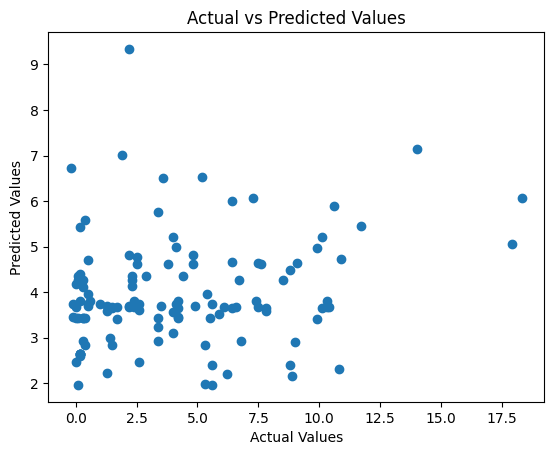

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor

# Create decision tree model instance
clf = DecisionTreeRegressor(max_depth=5, random_state=0)

# Create AdaBoost model instance with decision tree as the base estimator
model = AdaBoostRegressor(base_estimator=clf, random_state=0)

# Fit the AdaBoost model to the training data
model.fit(X_train, y_train)

# Predict on the training and test set
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Print the mean squared error and R^2 score for the test set
print('Test MSE: {0:0.4f}'. format(mean_squared_error(y_test, y_pred_test)))
print('Test R^2: {0:0.4f}'. format(r2_score(y_test, y_pred_test)))

# Create scatter plot of actual vs predicted values for test set
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()
